# Лекция 2: Невронни мрежи за NLP

**Продължителност:** 60-75 минути  
**Предпоставки:** Лекция 1 (ML основи, n-gram ограничения)  
**Следваща лекция:** Токенизация

## Цели на лекцията

- Разбиране защо невронните мрежи превъзхождат n-грами
- Научаване на embeddings - думи като вектори
- Изграждане и обучение на текстов класификатор
- Визуализация на научени представяния

---
## 1. Библиотеки и настройки

In [1]:
import numpy as np
import torch

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
from sklearn.datasets import fetch_20newsgroups
print("Библиотеки заредени")

Библиотеки заредени


---
## 2. Градивни елементи: Активационни функции

### Защо невронни мрежи?

**Ограничения на n-грами:**
- Sparsity: ненаблюдавани двойки → нулева вероятност
- Без генерализация: "cat sat" и "dog sat" несвързани
- Къс контекст

**Невронните мрежи:**
- Учат сходство между думи (embeddings)
- Генерализация чрез споделени представяния

### ReLU активация

Най-популярна функция: $f(z) = \max(0, z)$

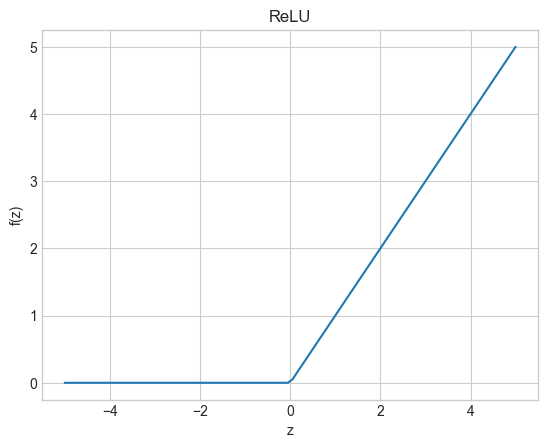

In [4]:
z = np.linspace(-5, 5, 100)
plt.plot(z, np.maximum(0, z)); plt.title('ReLU'); plt.xlabel('z'); plt.ylabel('f(z)'); plt.show()

### Sigmoid активация

За изходен слой: $\sigma(z) = \frac{1}{1 + e^{-z}}$

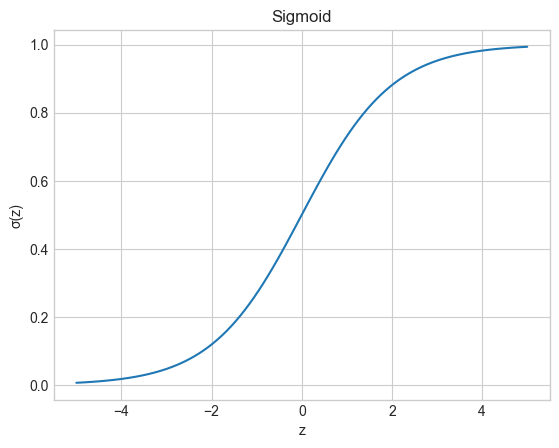

In [5]:
sigmoid = 1 / (1 + np.exp(-z))
plt.plot(z, sigmoid); plt.title('Sigmoid'); plt.xlabel('z'); plt.ylabel('σ(z)'); plt.show()

Sigmoid дава вероятности между 0 и 1

---
## 3. Embeddings: Думи като вектори

### Проблемът

Невронните мрежи работят с числа, текстът е дискретен.

**One-hot encoding** (лош подход):
- Огромна размерност (10,000+)
- Няма сходство: "cat" и "dog" еднакво различни

**Решение:** Плътни вектори с малка размерност

### Изграждане на речник

In [6]:
texts = ["the cat sat", "the dog sat", "cat and dog"]
vocab = {word: i for i, word in enumerate(set(' '.join(texts).split()))}

In [7]:
print(f"Речник: {vocab}")
print(f"Размер: {len(vocab)} думи")

Речник: {'sat': 0, 'cat': 1, 'and': 2, 'dog': 3, 'the': 4}
Размер: 5 думи


### Инициализация на embeddings

In [8]:
embed_dim = 5
embeddings = np.random.randn(len(vocab), embed_dim)

In [9]:
print(f"Embedding матрица: {embeddings.shape}")
print(f"Размер: {len(vocab)} думи × {embed_dim} измерения")

Embedding матрица: (5, 5)
Размер: 5 думи × 5 измерения


### Lookup за дума

In [10]:
word_idx = vocab['cat']
print(f"Embedding за 'cat': {embeddings[word_idx].round(3)}")

Embedding за 'cat': [-1.082  0.308 -2.132 -0.268 -0.444]


Всяка дума → плътен вектор с 5 числа

### Косинусово сходство

Мярка за близост: $\text{sim}(u, v) = \frac{u \cdot v}{||u|| \cdot ||v||}$

In [11]:
cat_vec = embeddings[vocab['cat']]
dog_vec = embeddings[vocab['dog']]
similarity = np.dot(cat_vec, dog_vec) / (np.linalg.norm(cat_vec) * np.linalg.norm(dog_vec))

In [12]:
print(f"Сходство cat-dog: {similarity:.3f}")
print("След обучение сходни думи → близки вектори")

Сходство cat-dog: -0.407
След обучение сходни думи → близки вектори


---
## 4. Forward Pass: От вход към изход

### Зареждане на прост dataset

In [13]:
data = fetch_20newsgroups(subset='train', categories=['alt.atheism', 'soc.religion.christian'], shuffle=True, random_state=42)
texts = data.data[:100]  # Само 100 примера за бързина

In [14]:
print(f"Примери: {len(texts)}")
print(f"Първи текст (първи 50 символа): {texts[0][:50]}...")

Примери: 100
Първи текст (първи 50 символа): From: nigel.allen@canrem.com (Nigel Allen)
Subject...


### Lookup embeddings за изречение

In [15]:
sentence_indices = [vocab.get(w, 0) for w in "the cat sat".split()]
sentence_embeds = embeddings[sentence_indices]

In [16]:
print(f"Форма на embeddings: {sentence_embeds.shape}")
print("3 думи × 5 измерения")

Форма на embeddings: (3, 5)
3 думи × 5 измерения


### Mean pooling

Усредняваме embeddings → един вектор за изречението

In [17]:
pooled = sentence_embeds.mean(axis=0)
print(f"Pooled вектор: {pooled.shape}")

Pooled вектор: (5,)


Сега имаме един вектор (5 числа) за цялото изречение

### Линеен слой

Трансформация: $z = Wx + b$

In [18]:
W = np.random.randn(10, 5) * 0.1
b = np.zeros(10)

In [19]:
hidden = W @ pooled + b
print(f"Скрит слой: {hidden.shape}")

Скрит слой: (10,)


### ReLU активация

In [20]:
activated = np.maximum(0, hidden)
print(f"След ReLU: {activated.round(3)}")

След ReLU: [0.02  0.075 0.041 0.    0.036 0.048 0.138 0.052 0.    0.   ]


Отрицателни стойности стават нула

### Sigmoid изход

In [21]:
W_out = np.random.randn(1, 10) * 0.1
logit = W_out @ activated

In [22]:
prediction = 1 / (1 + np.exp(-logit))
print(f"Предсказание: {prediction[0]:.3f} (вероятност)")

Предсказание: 0.498 (вероятност)


### Loss функция

Binary cross-entropy: $L = -[y\log(\hat{y}) + (1-y)\log(1-\hat{y})]$

In [23]:
y_true = 1.0
loss = -(y_true * np.log(prediction + 1e-10) + (1 - y_true) * np.log(1 - prediction + 1e-10))

In [24]:
print(f"Loss: {loss[0]:.3f}")
print("По-ниска loss → по-добър модел")

Loss: 0.697
По-ниска loss → по-добър модел


---
## 5. Обучение на текстов класификатор

### Подготовка на данните

Използваме PyTorch за автоматично градиентно спускане

In [25]:
from collections import Counter
import re

In [26]:
def tokenize(text):
    return re.findall(r'\b[a-z]+\b', text.lower())

### Изграждане на речник

In [27]:
all_words = Counter()
for text in texts:
    all_words.update(tokenize(text))

In [28]:
vocab_list = ['<pad>', '<unk>'] + [w for w, _ in all_words.most_common(1000)]
word2idx = {w: i for i, w in enumerate(vocab_list)}

In [29]:
print(f"Размер на речника: {len(vocab_list)}")
print(f"Топ думи: {vocab_list[2:7]}")

Размер на речника: 1002
Топ думи: ['the', 'of', 'to', 'is', 'that']


### Преобразуване на текст в индекси

In [30]:
def text_to_indices(text, max_len=50):
    tokens = tokenize(text)
    indices = [word2idx.get(w, word2idx['<unk>']) for w in tokens]
    return indices[:max_len] + [word2idx['<pad>']] * max(0, max_len - len(indices))

In [31]:
X = torch.tensor([text_to_indices(t) for t in texts])
y = torch.tensor(data.target[:100], dtype=torch.float32)

In [32]:
print(f"X форма: {X.shape}")
print(f"y форма: {y.shape}")

X форма: torch.Size([100, 50])
y форма: torch.Size([100])


### Train/test split

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(f"Обучаващи примери: {len(X_train)}")
print(f"Тестови примери: {len(X_test)}")

Обучаващи примери: 80
Тестови примери: 20


### Дефиниция на модела

In [35]:
import torch.nn as nn
import torch.nn.functional as F

In [36]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        embeds = self.embedding(x)
        pooled = embeds.mean(dim=1)
        hidden = F.relu(self.fc1(pooled))
        return torch.sigmoid(self.fc2(hidden)).squeeze()

In [37]:
model = TextClassifier(vocab_size=len(vocab_list), embed_dim=50, hidden_dim=128)
print(f"Параметри: {sum(p.numel() for p in model.parameters()):,}")

Параметри: 56,757


### Дефиниция на loss и оптимизатор

In [38]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Adam е стандартният оптимизатор (използва се в GPT, BERT)

### Обучителен цикъл

In [39]:
epochs = 50
train_losses = []

In [40]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Epoch 10: Loss = 0.6680
Epoch 20: Loss = 0.6408
Epoch 30: Loss = 0.6030
Epoch 40: Loss = 0.5486
Epoch 50: Loss = 0.4752


### Визуализация на обучението

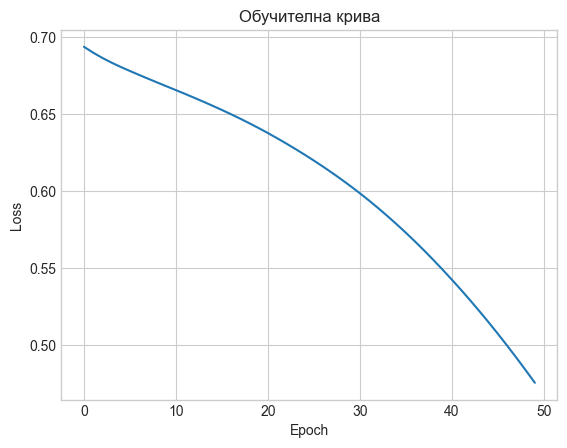

In [41]:
plt.plot(train_losses)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Обучителна крива'); plt.show()

Loss намалява → моделът се научава

### Оценка на тестови данни

In [42]:
model.eval()
with torch.no_grad():
    test_preds = (model(X_test) > 0.5).float()

In [43]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, test_preds)
print(f"Точност на тестови данни: {accuracy:.3f}")

Точност на тестови данни: 0.900


### Примерни предсказания

In [44]:
for i in range(3):
    text_sample = texts[i][:80]
    pred = test_preds[i].item() if i < len(test_preds) else model(X[i].unsqueeze(0)).item()
    true = y[i].item()
    print(f"Текст: {text_sample}...")
    print(f"  Истина: {int(true)}, Предсказание: {int(pred)}\n")

Текст: From: nigel.allen@canrem.com (Nigel Allen)
Subject: library of congress to host ...
  Истина: 1, Предсказание: 1

Текст: From: marshall@csugrad.cs.vt.edu (Kevin Marshall)
Subject: Re: some thoughts.
Or...
  Истина: 0, Предсказание: 1

Текст: From: tedr@athena.cs.uga.edu (Ted Kalivoda)
Subject: Re: Christianity and repeat...
  Истина: 1, Предсказание: 1



### Сравнение с Лекция 1

In [45]:
print("Лекция 1 (логистична регресия): ~85% точност")
print(f"Лекция 2 (невронна мрежа): {accuracy:.1%} точност")

Лекция 1 (логистична регресия): ~85% точност
Лекция 2 (невронна мрежа): 90.0% точност


Подобрение от научените embeddings!

---
## 6. Визуализация на научени embeddings

### Извличане на теглата

In [46]:
learned_embeddings = model.embedding.weight.detach().numpy()
print(f"Форма на embeddings: {learned_embeddings.shape}")

Форма на embeddings: (1002, 50)


### Намиране на близки думи

Сходство чрез косинусова дистанция

In [47]:
def find_similar(word, vocab_list, word2idx, embeddings, top_k=5):
    if word not in word2idx:
        return []
    word_vec = embeddings[word2idx[word]]
    sims = [(w, np.dot(word_vec, embeddings[i]) / (np.linalg.norm(word_vec) * np.linalg.norm(embeddings[i]) + 1e-10)) 
            for w, i in word2idx.items() if w not in ['<pad>', '<unk>']]
    return sorted(sims, key=lambda x: -x[1])[:top_k]

In [48]:
test_word = 'god' if 'god' in word2idx else vocab_list[10]
similar = find_similar(test_word, vocab_list, word2idx, learned_embeddings)
print(f"Думи близки до '{test_word}':")
for w, sim in similar:
    print(f"  {w}: {sim:.3f}")

Думи близки до 'god':
  god: 1.000
  kind: 0.404
  worse: 0.392
  works: 0.356
  cannot: 0.347


Сходни думи имат близки вектори!

### PCA визуализация

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(learned_embeddings[2:52])  # Първи 50 думи

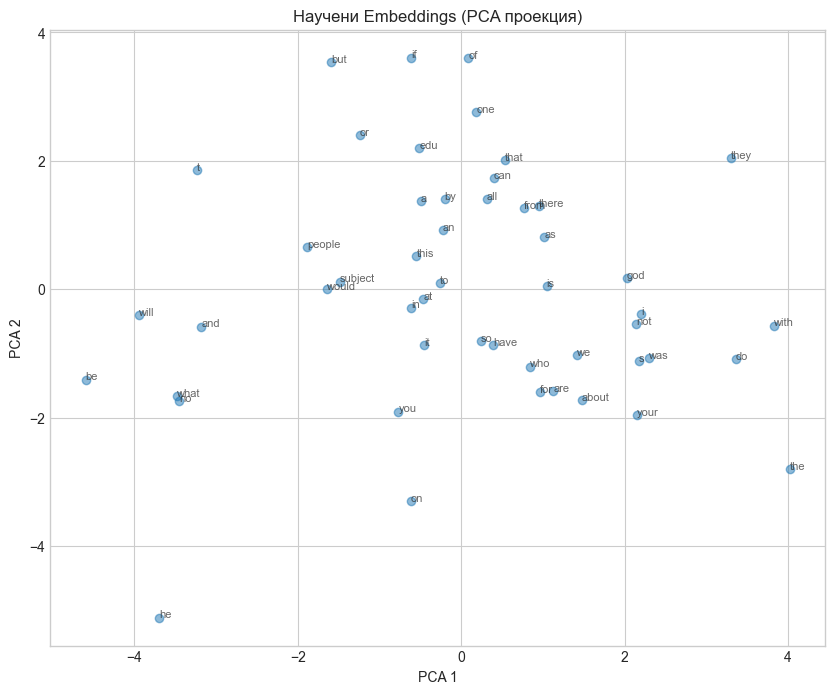

In [50]:
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
for i, word in enumerate(vocab_list[2:52]):
    plt.annotate(word, (coords[i, 0], coords[i, 1]), fontsize=8, alpha=0.7)
plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.title('Научени Embeddings (PCA проекция)'); plt.show()

Семантично близки думи са физически близо!

---
## 7. Ограничения и следваща стъпка

### Какво още не можем да обработим?

**Ред на думите:**
- "not good" vs "good not"
- Mean pooling губи реда

**Дълъг контекст:**
- Важни думи далеч една от друга

**Out-of-vocabulary:**
- Нови думи: "ChatGPT", "blockchain"
- Липсват в речника

### Проблемът с токенизацията

- Какво е "дума"? "New York" - една или две?
- "don't" - как да разделим?
- Редки думи, грешки, нови термини?

**Следваща лекция:** Модерна токенизация (BPE, WordPiece)

## Обобщение

**Научихме:**
1. Embeddings картират думи към вектори
2. Сходни думи → сходни вектори (научено от данни)
3. Невронни мрежи: слоеве от трансформации
4. Forward pass: вход → embeddings → скрит → изход
5. Backprop + Adam: как мрежите се научават
6. По-добро от n-грами и bag-of-words

**Следваща лекция:** Токенизация - как правилно да разделим текста

---
## Упражнения

1. **Променете размерността на embeddings** от 50 на 100. Подобрява ли се точността?
2. **Max pooling вместо mean pooling**: Заменете `.mean(dim=1)` с `.max(dim=1)[0]`. Сравнете резултатите.
3. **Търсене на аналогии**: Изчислете "good" - "bad" + "big" ≈ ? Има ли смисъл?

---
## Ресурси

- Jurafsky & Martin, Ch. 7: Neural Networks
- 3Blue1Brown: Neural Networks серия
- PyTorch Tutorial: Building Neural Networks

---
**Въпроси?**